In [1]:
import pandas as pd

# Direct public dataset link
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1) Quick check ---
print("Columns:", df.columns.tolist())
print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# --- 2) Clean TotalCharges (it is often stored as text with blanks) ---
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows where TotalCharges became NaN after conversion
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

# --- 3) Convert target to 0/1 ---
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# --- 4) Drop customerID (it's just an identifier, not useful for prediction) ---
df = df.drop(columns=["customerID"])

# --- 5) (Feature Engineering) Add AvgCharges ---
df["AvgCharges"] = df["TotalCharges"] / df["tenure"].replace(0, np.nan)
df["AvgCharges"] = df["AvgCharges"].fillna(0)

print("\nAfter cleaning:")
print("Shape:", df.shape)
print("Churn distribution:\n", df["Churn"].value_counts(normalize=True))

# --- 6) Split into features and target ---
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train/test split (stratify keeps churn ratio same in train and test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values (top 10):
customerID         0
gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
dtype: int64

After cleaning:
Shape: (7032, 21)
Churn distribution:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

Train shape: (5625, 20) Test shape: (1407, 20)


In [3]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1) Identify numeric and categorical columns (from your X_train)
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

# 2) Preprocessing: scale numeric + one-hot categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# 3) Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# 4) Train and evaluate each model
results = []
trained_models = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    # ROC-AUC needs probabilities (or decision scores)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba (rare here), fallback
        y_proba = pipe.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append([name, acc, f1, auc])
    trained_models[name] = pipe

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1", "ROC_AUC"])
results_df = results_df.sort_values("ROC_AUC", ascending=False).reset_index(drop=True)

results_df

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,Model,Accuracy,F1,ROC_AUC
0,Logistic Regression,0.803838,0.607955,0.835991
1,Random Forest,0.793177,0.561086,0.816753
2,SVM,0.796731,0.565350,0.788753
3,KNN,0.766169,0.575484,0.783144
4,Decision Tree,0.721393,0.488251,0.650532


In [5]:
from sklearn.model_selection import GridSearchCV

# Build pipeline again
logreg_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=5000))
])

# Hyperparameter grid
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid = GridSearchCV(
    logreg_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

Best Parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8460076769214574


In [7]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Tuned Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Tuned Test ROC-AUC: 0.8348263973370744
Accuracy: 0.798862828713575
F1 Score: 0.6019690576652602


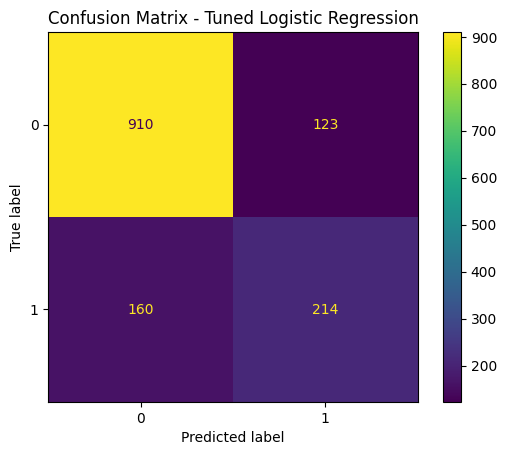

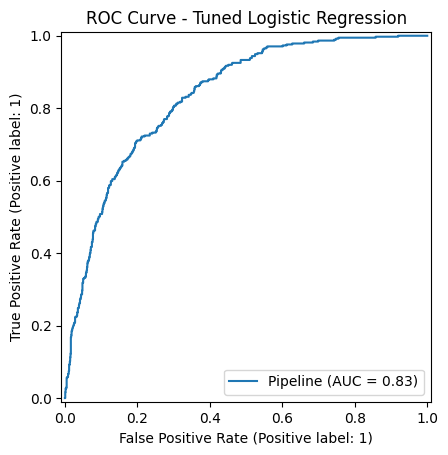

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Tuned Logistic Regression")
plt.show()

In [10]:
import joblib

joblib.dump(best_model, "churn_model_logreg.joblib")
print("Saved model as churn_model_logreg.joblib")

Saved model as churn_model_logreg.joblib


In [11]:
# Get feature names after one-hot encoding
ohe = best_model.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

# Get coefficients
coefs = best_model.named_steps["model"].coef_[0]

fi = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

fi.head(15)

,feature,coef,abs_coef
2,MonthlyCharges,-2.491439,2.491439
17,InternetService_Fiber optic,1.412610,1.412610
1,tenure,-1.404505,1.404505
16,InternetService_DSL,-1.227648,1.227648
39,Contract_Two year,-0.844385,0.844385
3,TotalCharges,0.696117,0.696117
18,InternetService_No,-0.651273,0.651273
23,OnlineBackup_No internet service,-0.651273,0.651273
29,TechSupport_No internet service,-0.651273,0.651273
26,DeviceProtection_No internet service,-0.651273,0.651273
